In [1]:
import pandas as pd
import numpy as np
from numpy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

import warnings
warnings.filterwarnings("ignore")

# 1. Load datasets 

In [2]:
df = pd.read_json("train.json")

In [3]:
df.head(1)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium


# 2. Transform "created" column to numeric features

In [4]:
df["created"] = pd.to_datetime(df["created"])
df["created_year"] = df["created"].dt.year
df["created_month"] = df["created"].dt.month
df["created_day"] = df["created"].dt.day

# 3. Extract numeric features and label

In [5]:
numeric_features = ["bathrooms", "bedrooms", "latitude", "longitude", "price", "created_year", "created_month", "created_day"]

target_num_map = {'high':0, 'medium':1, 'low':2}
target_names = ['high', 'medium', 'low']

X = df[numeric_features]
y = np.array(df['interest_level'].apply(lambda x: target_num_map[x]))

# 4. Split train and test set

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# 5. Train and test

## 5.1 Random forest

In [7]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
y_test_predict = random_forest.predict(X_test)

#### Accuracy

In [8]:
print("accuracy: {}".format(accuracy_score(y_test_predict, y_test)))

accuracy: 0.7041839732549894


#### Precision-Recall curve

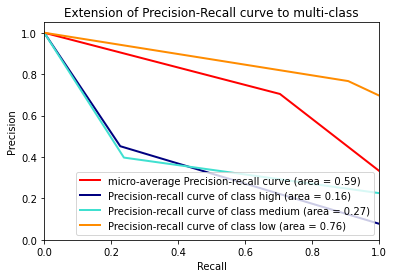

In [9]:
y = label_binarize(y_test, classes=[0,1,2])
score = label_binarize(y_test_predict, classes=[0,1,2])

precision = dict()
recall = dict()
average_precision = dict()

for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(y[:, i],
                                                        score[:, i])
    average_precision[i] = average_precision_score(y[:, i], score[:, i])


colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
precision["micro"], recall["micro"], _ = precision_recall_curve(y.ravel(), score.ravel())
average_precision["micro"] = average_precision_score(y, score, average="micro")

plt.clf()
plt.plot(recall["micro"], precision["micro"], color='red', lw=2,
         label='micro-average Precision-recall curve (area = {0:0.2f})'
               ''.format(average_precision["micro"]))
for i, color in zip(range(len(target_names)), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='Precision-recall curve of class {0} (area = {1:0.2f})'
                   ''.format(target_names[i], average_precision[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(loc="lower right")
plt.show()

####  Classification report

In [10]:
print(classification_report(y_test_predict, y_test, target_names=target_names))

              precision    recall  f1-score   support

        high       0.23      0.45      0.30       385
      medium       0.24      0.40      0.30      1335
         low       0.91      0.77      0.83      8151

    accuracy                           0.70      9871
   macro avg       0.46      0.54      0.48      9871
weighted avg       0.79      0.70      0.74      9871



#### Confusion matrix

In [11]:
print(confusion_matrix(y_test, y_test_predict))

[[ 174  248  344]
 [ 136  530 1560]
 [  75  557 6247]]


#### ROC curve

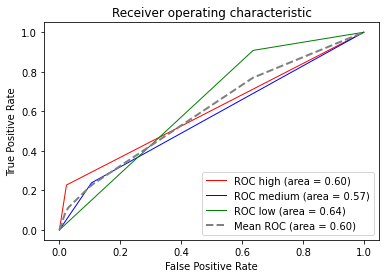

In [12]:
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
labels = ['high','medium','low']
colors = ['red', 'blue', 'green', 'grey']

for i in range(3):
    fpr, tpr, _ = roc_curve(y[:,i], score[:,i])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, color=colors[i],
             label='ROC %s (area = %0.2f)' % (labels[i], roc_auc))

mean_tpr /= 3
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='grey', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## 5.2 Support Vector Machine

## 5.3 Ada Boost